In [ ]:
# This tests how we find errors for our calibration program star metallicities, and how we
# find final error bars on our calibration solution coefficients

# created 2018 Jan 14 by E.S.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
from astropy.modeling.functional_models import Gaussian2D
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

In [2]:
# make some fake data representing the metallicities and errors of stars from the literature

fake_data_1 = {"star_name": ["AA Aql","AO Peg","BR Aqr","CI And","DM Cyg","DO Vir","DX Del","X Ari"],
                "feh_lit": [-1.1,-0.6,-1.29,-1.22,-0.69,-0.43,-0.04,-2.51],
                "feh_layden": [-1.05,-0.9,-1.15,-1.2,-0.45,-0.7,0.0,-2.1],
                "err_feh_lit": [0.3,0.3,0.3,0.4,0.2,0.35,0.3,0.4],
                "err_feh_layden": [0.06,0.06,0.07,0.06,0.07,0.06,0.06,0.07]}

fake_dataset_1 = pd.DataFrame(data=fake_data_1)

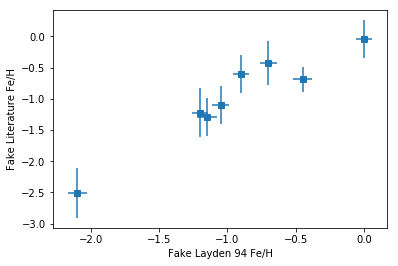

In [3]:
plt.errorbar(fake_data_1["feh_layden"], fake_data_1["feh_lit"], 
             yerr=fake_data_1["err_feh_lit"], xerr=fake_data_1["err_feh_layden"], marker="s", linestyle='')
plt.xlabel("Fake Layden 94 Fe/H")
plt.ylabel("Fake Literature Fe/H")
plt.savefig("fake_data.png")
#plt.show()

# Step 1: Find the linear regression line to high_res vs. basis Fe/H values

In [4]:
# Put Fe/H values into a useable form

feh_sample = np.transpose([fake_data_1["feh_layden"],fake_data_1["feh_lit"]])

In [5]:
N_samples = int(1e4)

# set RNG for reproducibility
with NumpyRNGContext(1):
    bootresult = bootstrap(feh_sample, N_samples)

In [ ]:
# for testing results with different seeds
#bootresult = bootstrap(feh_sample, N_samples)

In [6]:
def cdf_fcn(array_input):
    '''
    Return CDF of an unsorted input array of values
    '''
    
    number_cum_norm = np.divide(np.arange(len(array_input)),len(array_input))
    array_input_sort = np.sort(array_input)
    array_cdf = np.divide(np.cumsum(array_input_sort),np.cumsum(array_input_sort)[-1])
    
    return array_input_sort, number_cum_norm

In [18]:
def cdf_gauss(x_range, mu, sig):
    '''
    Returns the CDF of a general Gaussian function for any mu and sig
    '''
    
    x_range_adjust = np.divide(np.subtract(x_range, mu), sig) # rescale x -> x* = (x-mu)/sig
    erf_return = scipy.special.erf(np.divide(x_range_adjust,np.sqrt(2))) # erf(x*/sqrt(2))
    
    return np.multiply(0.5,np.add(1., erf_return)) # (1/2)*(1 + erf(x*/sqrt(2)))

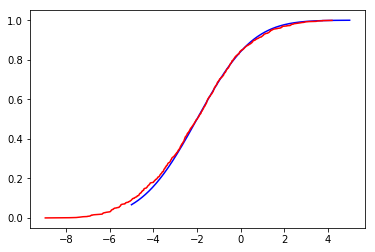

In [19]:
# test of cdf_fcn and cdf_gauss

x_range = np.arange(-5,5,0.01)
mu = -2.
sig = 2

# sample from a gaussian distribution
gaussian_samples = np.random.normal(loc=mu, scale=sig, size=len(x_range))

# test my cdf_fcn
x_range1, y_range1 = cdf_fcn(gaussian_samples)

# test my cdf_gauss fcn
y_range = cdf_gauss(x_range, mu, sig)

plt.plot(x_range, y_range, color='blue')
plt.plot(x_range1, y_range1, color='red')
plt.show()


In [20]:
m_array = np.nan*np.ones(len(bootresult))
b_array = np.nan*np.ones(len(bootresult))
for boot_n in range(0,len(bootresult)):
    test_fit = np.polyfit(bootresult[boot_n,:,0], bootresult[boot_n,:,1], 1)
    m_array[boot_n] = test_fit[0]
    b_array[boot_n] = test_fit[1]

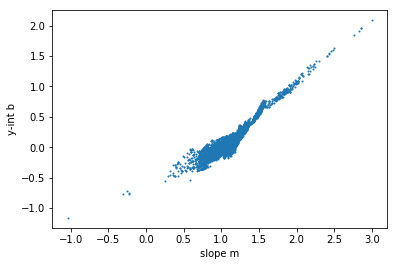

In [10]:
plt.scatter(m_array,b_array,s=1)
plt.xlabel("slope m")
plt.ylabel("y-int b")
plt.show()

[1.14066129 0.16518056]


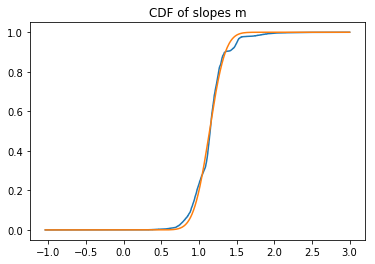

In [23]:
# make empirical CDF
x_vals, y_vals = cdf_fcn(m_array)

# fit a Gaussian
popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)
print(popt)

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cdf_gauss(x_vals, *popt))
plt.title("CDF of slopes m")
plt.show()

[0.08862982 0.16708251]


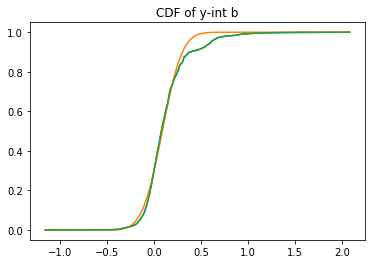

In [24]:
x_vals, y_vals = cdf_fcn(b_array)

# fit a Gaussian
popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)
print(popt)

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cdf_gauss(x_vals, *popt))

plt.plot(x_vals, y_vals)
plt.title("CDF of y-int b")
plt.show()

In [34]:
# take one basis set Fe/H and find what the mapped value should be 

feh_test = fake_data_1["feh_layden"][0]
feh_mapped_array = np.nan*np.ones(len(m_array))

for sample_num in range(0,len(m_array)):
    
    feh_mapped_1sample = m_array[sample_num]*feh_test + b_array[sample_num]
    feh_mapped_array[sample_num] = feh_mapped_1sample

In [35]:
feh_test

-1.05

[-1.0812096   0.08522809]


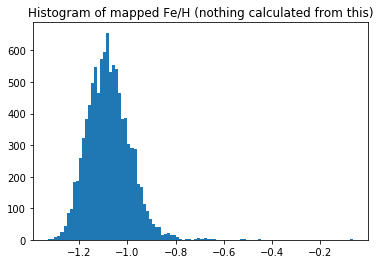

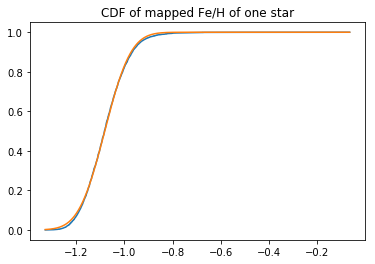

In [37]:
x_vals, y_vals = cdf_fcn(feh_mapped_array)

# fit a Gaussian
popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)
print(popt)

plt.hist(feh_mapped_array, bins=100)
plt.title("Histogram of mapped Fe/H (nothing calculated from this)")
plt.show()

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cdf_gauss(x_vals, *popt))
plt.title("CDF of mapped Fe/H of one star")
plt.show()

NameError: name 'df_posterior_sample' is not defined

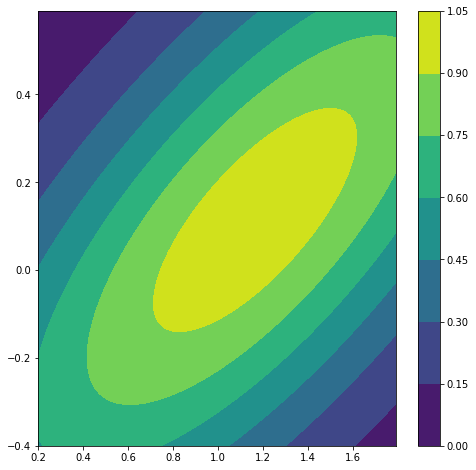

In [5]:
# Gaussian posterior of line parameters, w/ y: y-int, x: slope m

xvalues = np.arange(start = 0.2, stop = 1.8, step = 0.01)
yvalues = np.arange(start = -0.4, stop = 0.6, step = 0.01)

xx, yy = np.meshgrid(xvalues, yvalues)

g2d = Gaussian2D(amplitude=1, 
           x_mean=1.16441617, 
           y_mean=0.11391776, 
           x_stddev=np.sqrt(1.16441617), 
           y_stddev=np.sqrt(0.11391776), 
           theta=35)

plt.figure(figsize = (8,8))
plt.contourf(xx, yy, g2d(xx, yy), origin="lower")
plt.colorbar()
plt.scatter(df_posterior_sample["x_rand_sample"],df_posterior_sample["y_rand_sample"])
plt.xlabel("slope m")
plt.ylabel("y-intercept b")
#plt.savefig("posterior_sample_test.png")
plt.show()

In [6]:
# generate N random points, and keep those below the contour

N = 1000
x_rand_sample = np.random.uniform(low=xvalues[0], high=xvalues[-1], size=N)
y_rand_sample = np.random.uniform(low=yvalues[0], high=yvalues[-1], size=N)
z_rand_sample = np.random.uniform(low=0, high=1, size=N)

df = pd.DataFrame(x_rand_sample, columns=["x_rand_sample"])
df["y_rand_sample"] = y_rand_sample
df["z_rand_sample"] = z_rand_sample

# consider points below the contour
df_posterior_sample = df.where(g2d(df["x_rand_sample"], df["y_rand_sample"]) > df["z_rand_sample"]).dropna().reset_index()

In [7]:
# now draw from the samples of the posterior, and the Gaussian curve around each Layden Fe/H value

# loop over each Layden Fe/H value
for lay in range(0,len(fake_data_1["feh_layden"])):

    mapped_feh_array = np.nan*np.ones(len(df_posterior_sample))
    
    # loop over each sample of the posterior
    for q in range(0,len(df_posterior_sample)):
    
        layden_feh = fake_data_1["feh_layden"][lay]
        
        # draw a Layden 94 FeH within the error he gives 
        layden_feh_sample = layden_feh*(1. + np.random.normal(loc=0.0, scale=fake_data_1["err_feh_layden"][lay] ))
        
        # make a mapped FeH for each combination of 
        # slope
        # y-intercept
        # FeH from Layden 94 (his value plus error)
        mapped_feh = layden_feh_sample*df_posterior_sample["x_rand_sample"][q] + df_posterior_sample["y_rand_sample"][q]
        mapped_feh_array[q] = mapped_feh
        #print(layden_feh_sample)
        
    plt.hist(mapped_feh_array, bins = 100)
    plt.title("Layden Fe/H: "+str(fake_data_1["feh_layden"][lay])+
              "\n median: "+str(np.median(mapped_feh_array))+
              "\n mean: "+str(np.mean(mapped_feh_array))+
              "\n stdev: "+str(np.std(mapped_feh_array)))
    plt.tight_layout()
    #plt.savefig("fake_mapped_"+str(lay)+".png")
    plt.clf()

<Figure size 432x288 with 0 Axes>

# Step 2: Find the remapping of literature metallicities, with errors

# Step 3: Find the calibration coefficients (a,b,c,d) with errors